# GraphSage Rewiring on Enzymes Dataset

In [24]:
import networkx as nx
import pandas as pd
import torch
import numpy as np
import os
import random
import sklearn
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout

from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight


import matplotlib.pyplot as plt
from torch_geometric.utils import to_dense_adj
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.nn import global_max_pool
from torch.nn import Sequential, Linear, ReLU


from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader



In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Downloading Enzymes Dataset


In [3]:
from torch_geometric.datasets import TUDataset
enzymes = TUDataset(root = 'Over_Squashing_GNNs/data/Enzymes', name = 'ENZYMES')
print(enzymes)
print("len:", len(enzymes))
print("num_classes:", enzymes.num_classes)
print("num_node_features:", enzymes.num_node_features)

ENZYMES(600)
len: 600
num_classes: 6
num_node_features: 3


In [4]:
for i in range(10):
  sample = enzymes[i]
  print(sample)

Data(edge_index=[2, 168], x=[37, 3], y=[1])
Data(edge_index=[2, 102], x=[23, 3], y=[1])
Data(edge_index=[2, 92], x=[25, 3], y=[1])
Data(edge_index=[2, 90], x=[24, 3], y=[1])
Data(edge_index=[2, 90], x=[23, 3], y=[1])
Data(edge_index=[2, 92], x=[24, 3], y=[1])
Data(edge_index=[2, 118], x=[26, 3], y=[1])
Data(edge_index=[2, 266], x=[88, 3], y=[1])
Data(edge_index=[2, 78], x=[23, 3], y=[1])
Data(edge_index=[2, 106], x=[32, 3], y=[1])


### Finding Bridges in a Graph


Graph 1


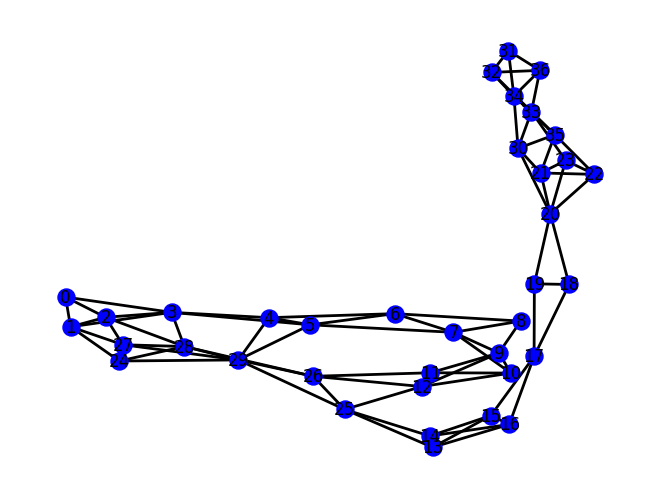

Graph 2


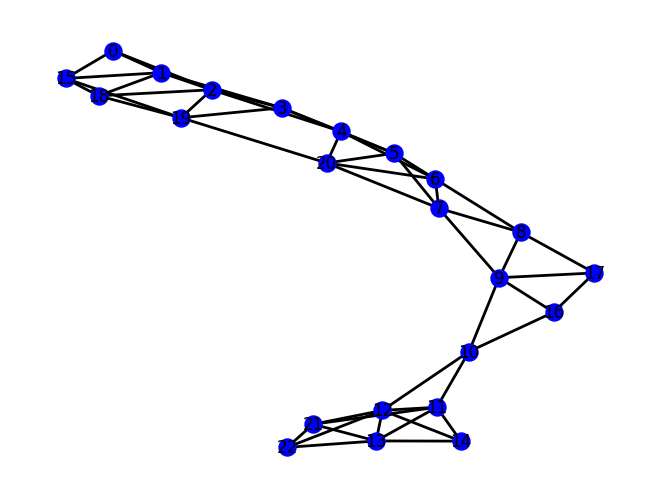

Graph 3


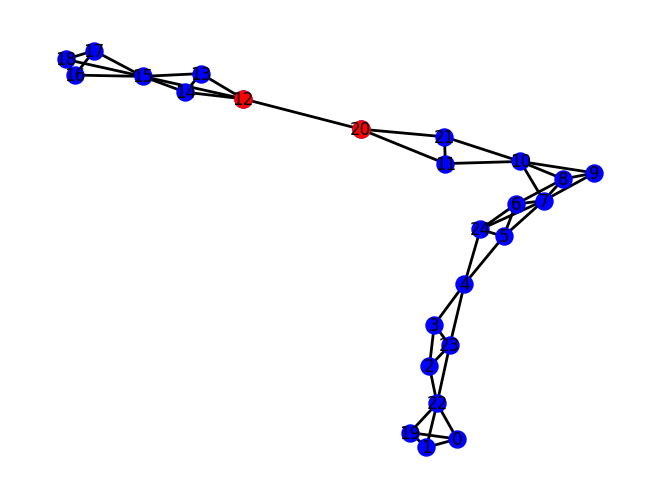

Graph 4


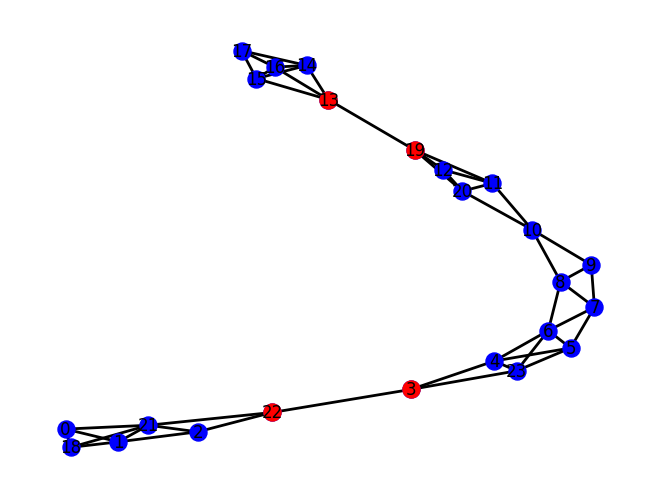

Graph 5


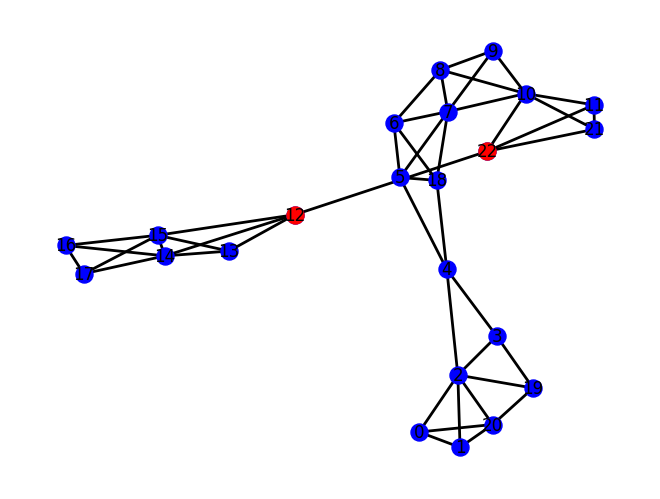

Graph 6


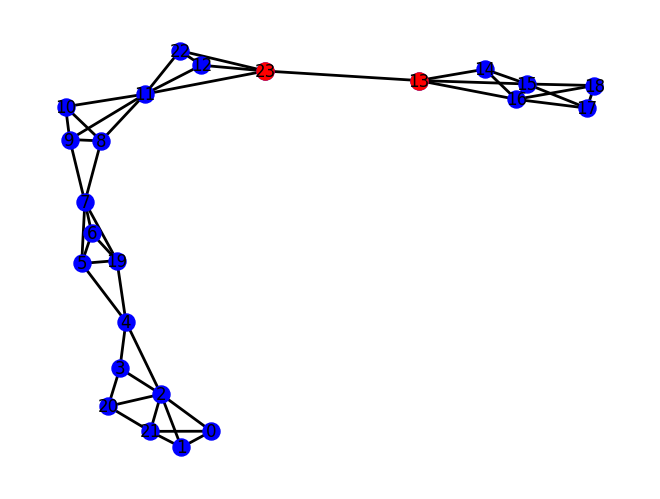

Graph 7


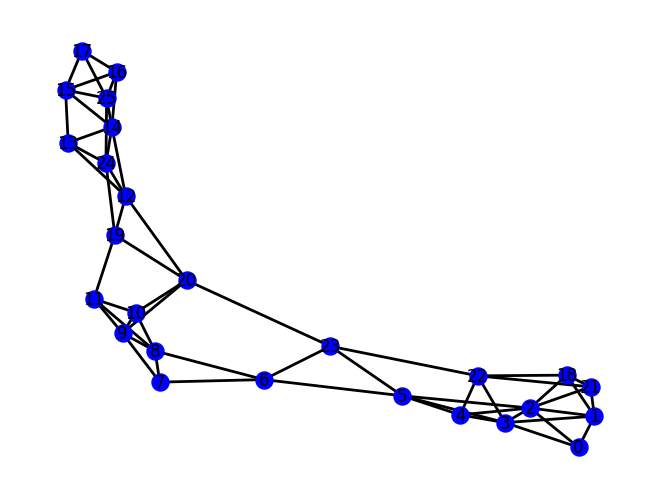

Graph 8


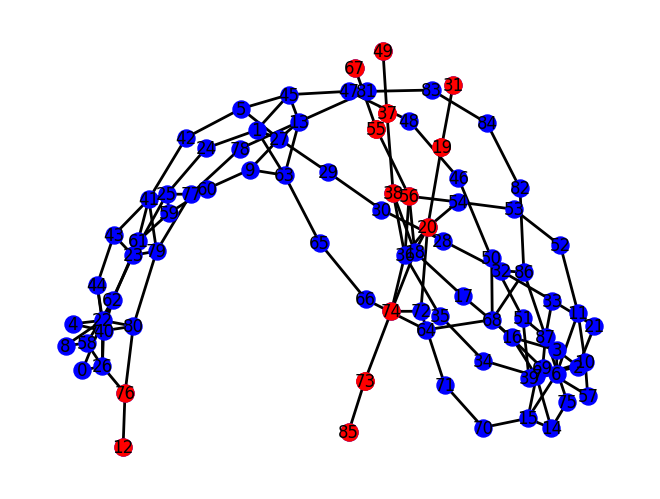

Graph 9


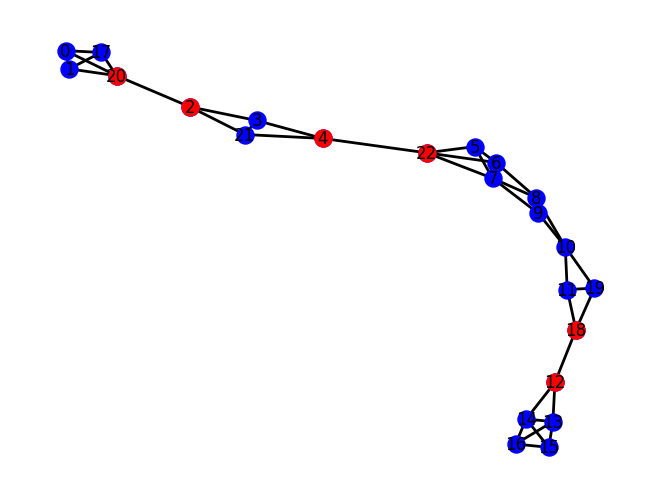

Graph 10


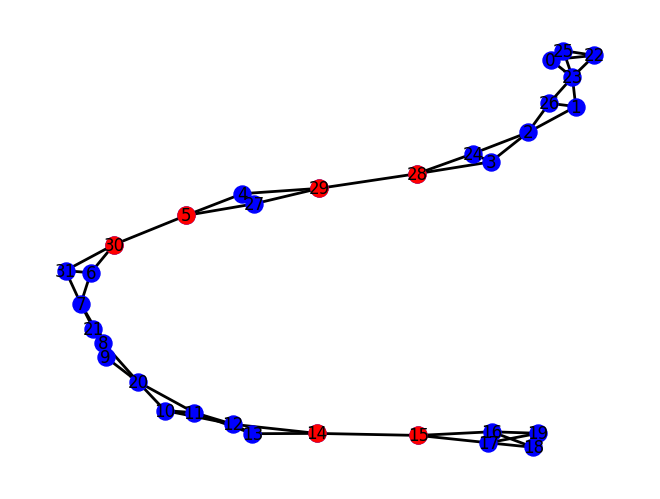

In [5]:
for i in range(10):
  data = enzymes[i]
  G = to_networkx(data,to_undirected = True)
  pos = nx.spring_layout(G)
  nx.draw(G, pos, node_color = 'blue', edge_color = 'black',
          node_size = 150, width = 2, with_labels = True)
  bridges = nx.bridges(G)
  print(f"Graph {i+1}")
  for bridge in bridges:
    nx.draw_networkx_nodes(G, pos, nodelist = bridge, node_color = 'red', node_size = 150)

  plt.show()

In [7]:
Gx = to_networkx(enzymes[9],to_undirected = True)
subgraph = Gx.subgraph(list(G.nodes())[:500])
#pos = nx.spring_layout(subgraph)

subgraph_bridges = list(nx.bridges(subgraph))

In [8]:
## Nodes and Node Feature size
example = enzymes[0]
y = example.x.shape  #([number of nodes, num_node_features])
print(y[0], y[1])

37 3


## Rewiring

### Rewiring 1
### - rewires all the adjacent nodes of the bridges

In [6]:
def rewire1(data): # this connects all the adjacent nodes of the bridges together(no triangular rewiring)
  g6 = to_networkx(data, to_undirected = True)
  bridges = list(nx.bridges(g6))

  adj_node_dict = {}
# Get all neighbors for each bridge node
  for u, v in bridges:
      for node in (u, v):
          adj_nodes = list(nx.all_neighbors(g6, node))
          adj_node_dict[node] = adj_nodes

  adj_node_dict = {key: value for key, value in adj_node_dict.items() if len(value) > 1}


 # Rewire nodes by connecting neighbors of each bridge node
  for u, v in bridges:
    neighbors_u = adj_node_dict.get(u,[])
    neighbors_v = adj_node_dict.get(v,[])

    for node_u in neighbors_u:
      for node_v in neighbors_v:
        if not g6.has_edge(node_u, node_v): # if the edge does not already exist
          g6.add_edge(node_u, node_v) # add the edge

      # Create edge_index tensor directly from edge
    edges = list(g6.edges())
    edge_index = torch.tensor(edges, dtype=torch.long).t()
    
    # Make undirected by adding reverse edges
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    
    # Remove duplicate edges and sort
    edge_index = torch.unique(edge_index, dim=1)
    
    # Ensure contiguous memory layout
    edge_index = edge_index.contiguous()
  return edge_index.to(device)



In [7]:
edge_index1 = [rewire1(enzymes[i]) for i in range(len(enzymes))]


UnboundLocalError: local variable 'edge_index' referenced before assignment

In [18]:
print(edge_index1[0])
print(len(edge_index1))

NameError: name 'edge_index1' is not defined

### Rewire 2:
### Connecting the adjacent nodes to the other bridge node

In [8]:
def rewire2(data):
    g6 = to_networkx(data, to_undirected=True)
    bridges = list(nx.bridges(g6))
    adj_node_dict = {}
    #print(bridges)

    filtered_bridges = [bridge for bridge in bridges
                        if len(list(g6.neighbors(bridge[0]))) > 1 and
                        len(list(g6.neighbors(bridge[1]))) > 1]
    #print(filtered_bridges)

    # Get all neighbors for each bridge node
    for u, v in filtered_bridges:
        for node in (u, v):
            adj_nodes = list(nx.all_neighbors(g6, node))
            adj_node_dict[node] = adj_nodes

    # Filter to only include nodes with more than one neighbor
    adj_node_dict = {key: value for key, value in adj_node_dict.items() if len(value) > 1}
    keys = set(adj_node_dict.keys())

    for key, values in adj_node_dict.items():
      # Remove any bridge node found in the list
      adj_node_dict[key] = [v for v in values if v not in keys]

    for u, v in filtered_bridges: # 17,18
        neighbors_u = adj_node_dict.get(u, []) # 18, 19
        neighbors_v = adj_node_dict.get(v, []) #
        #print(f"Bridge ({u}, {v}): Neighbors of {u}: {neighbors_u}, Neighbors of {v}: {neighbors_v}")
        # Only connect each neighbor of u to v, without connecting neighbors to each other
        for node_u in neighbors_u:
            if node_u != v and not g6.has_edge(node_u, v):  # Ensure we only connect to v

                g6.add_edge(node_u, v)

        # Only connect each neighbor of v to u, without connecting neighbors to each other
        for node_v in neighbors_v:
            if node_v != u and not g6.has_edge(node_v, u):  # Ensure we only connect to u
                g6.add_edge(node_v, u)

    adj_matrix = nx.adjacency_matrix(g6).toarray()
    # function should return the edge_index

    edge_index = torch.tensor(adj_matrix, dtype=torch.long)
    

    edge_index = edge_index.nonzero().t().contiguous() # (2,num_edges) format and contigous memory.



    return edge_index.to(device)
edge_index2 = [rewire2(enzymes[i]) for i in range(len(enzymes))]
print(edge_index2[0])
print(len(edge_index2))
print(edge_index2[0].shape)

tensor([[ 0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
          3,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12,
         12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16,
         16, 16, 17, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 20, 20,
         21, 21, 21, 21, 21, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25,
         25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28,
         28, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 32,
         32, 32, 32, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 35, 35, 35,
         35, 35, 36, 36, 36, 36],
        [ 1,  2,  3,  0,  2,  3, 24, 27,  0,  1,  3, 27, 28,  0,  1,  2,  4,  5,
         28,  3,  5,  6, 29,  3,  4,  6,  7, 29,  4,  5,  7,  8,  5,  6,  8,  9,
         10,  6,  7,  9,  7,  8, 10, 11, 12,  7,  9, 11, 12,  9, 10, 12, 26

### Rewire 3:

### Combines rewire1 and rewire2

In [9]:
def rewire_combined(data):
    g = to_networkx(data, to_undirected=True)
    g6 = g.copy()


    bridges = list(nx.bridges(g6))
    adj_node_dict = {}


    filtered_bridges = [bridge for bridge in bridges
                        if len(list(g6.neighbors(bridge[0]))) > 1 and
                        len(list(g6.neighbors(bridge[1]))) > 1]


    for u, v in filtered_bridges:
        for node in (u, v):
            adj_nodes = list(nx.all_neighbors(g6, node))
            adj_node_dict[node] = adj_nodes


    adj_node_dict = {key: [v for v in value if len(value) > 1 and v not in adj_node_dict]
                     for key, value in adj_node_dict.items()}


    for u, v in filtered_bridges:
        neighbors_u = adj_node_dict.get(u, [])
        neighbors_v = adj_node_dict.get(v, [])


        for node_u in neighbors_u:
            if node_u != v and not g6.has_edge(node_u, v):
                g6.add_edge(node_u, v)
        for node_v in neighbors_v:
            if node_v != u and not g6.has_edge(node_v, u):
                g6.add_edge(node_v, u)


        for node_u in neighbors_u:
            for node_v in neighbors_v:
                if node_u != node_v and not g6.has_edge(node_u, node_v):
                    g6.add_edge(node_u, node_v)

        adj_matrix = nx.adjacency_matrix(g6).toarray()
        # function should return the edge_index

        edge_index = torch.tensor(adj_matrix, dtype=torch.long)

        edge_index = edge_index.nonzero().t().contiguous() # (2,num_edges) format and contigous memory.



    return edge_index.to(device)



In [10]:
edge_index3 = [rewire_combined(enzymes[i]) for i in range(len(enzymes))]
print(edge_index3[0])
print(len(edge_index3))

UnboundLocalError: local variable 'edge_index' referenced before assignment

### GraphSAGE with normal wiring


In [98]:
class GraphSAGE_1(torch.nn.Module):
    def __init__(self, num_layers, num_node_features=3, dim_h=128):
        super().__init__()

        self.num_layers = num_layers
        self.batch_norms = torch.nn.ModuleList()
        self.sages = torch.nn.ModuleList()

        self.batch_norms.append(BatchNorm1d(dim_h))
        self.sages.append(SAGEConv(num_node_features, dim_h, aggr='mean', normalize=True))

        for i in range(1, num_layers - 1):
            output_dim = dim_h // (2 ** i)
            self.batch_norms.append(BatchNorm1d(output_dim))
            self.sages.append(SAGEConv(dim_h // (2 ** (i - 1)), output_dim, aggr='mean', normalize=True))

        final_output_dim = dim_h // (2 ** (num_layers - 1))
        self.batch_norms.append(BatchNorm1d(final_output_dim))
        self.sages.append(SAGEConv(dim_h // (2 ** (num_layers - 2)), final_output_dim, aggr='mean', normalize=True))

        self.lin = Linear(final_output_dim, 6)

    def forward(self, x, edge_index, batch):
        for i in range(self.num_layers):
            h = self.sages[i](x, edge_index)
            h = self.batch_norms[i](h)
            h = F.elu(h)
            h = F.dropout(h, p=0.5, training=self.training)
            x = h

        h = global_mean_pool(h, batch)
        x = self.lin(h)
        return x

In [95]:
num_node_features = 3
# num_node_features is the number of node features.

# from binascii import a2b_hex

# from torch_geometric.nn import SAGEConv
# import itertools
# edges = list(itertools.permutations(range(18),2))
# full_adj = torch.tensor(edges,dtype = torch.long).t().contiguous().to(device)
class GraphSAGE(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()

        self.batch_norm1 = BatchNorm1d(dim_h)
        self.batch_norm2 = BatchNorm1d(dim_h//2)
        self.batch_norm3 = BatchNorm1d(dim_h//4)
        self.sage1 = SAGEConv(num_node_features, dim_h, aggr='mean',
            normalize=True) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2, aggr='mean',
            normalize=True) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4, aggr='mean',normalize=True) # 64 * 32
        self.lin = Linear((dim_h//4), 6)  # 64 * 1 output = 6


    def forward(self, x, edge_index, batch):

#(32x64 and 32x1)
        h1 = self.sage1(x, edge_index) # 7 * 128
        h1 = self.batch_norm1(h1)
        h = F.elu(h1) # 128
        h = F.dropout(h, p=0.5, training=self.training) # 128
        h2 = self.sage2(h, edge_index) # 128 * 64
        h2 = self.batch_norm2(h2)
        h = F.elu(h2)
        h = F.dropout(h, p=0.5, training=self.training)
        h3 = self.sage3(h,edge_index) # 64 * 32
        h3 = self.batch_norm3(h3)
        h = F.elu(h3)
        h = global_mean_pool(h, batch) # 32 * 32
       # h = F.dropout(h, p=0.5, training=self.training)
        x = self.lin(h) # 32 * 6
        return x # x givs output of 6 classes Shape: 32 * 6
        # return F.log_softmax(x, dim=1)



### GraphSAGE with Full Adjacency

In [34]:

# num_node_features is the number of node features.

# from binascii import a2b_hex
import itertools
num_node_features = 3


class GraphSAGE_FA(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.batch_norm1 = BatchNorm1d(dim_h)
        self.batch_norm2 = BatchNorm1d(dim_h//2)
        self.batch_norm3 = BatchNorm1d(dim_h//4)
        self.sage1 = SAGEConv(num_node_features, dim_h, aggr='mean',
            normalize=True) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2, aggr='mean',
            normalize=True) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4, aggr='mean',normalize=True) # 64 * 32
        self.lin = Linear((dim_h//4), 6)  # 32 * 1

    def forward(self, x, edge_index, batch):

        h1 = self.sage1(x, edge_index) # 7 * 128
        h1 = self.batch_norm1(h1)
        h = F.elu(h1) # 128
        h = F.dropout(h, p=0.5, training=self.training) # 128
        h2 = self.sage2(h, edge_index) # 128 * 64
        h2 = self.batch_norm2(h2)
        h = F.elu(h2)
        h = F.dropout(h, p=0.5, training=self.training)

        num_nodes = x.size(0)
        full_edges = torch.combinations(torch.arange(num_nodes), r=2).t().contiguous()  # Generate all pairs
        full_edge_index = torch.cat([full_edges, full_edges.flip(0)], dim=1)  # Make it undirected
        full_edge_index = full_edge_index.to(h.device)

        h3 = self.sage3(h,full_edge_index) # 64 * 32
        h3 = self.batch_norm3(h3)
        h = F.elu(h3)
        h = global_mean_pool(h, batch) # 32 * 32
       # h = F.dropout(h, p=0.5, training=self.training)
        x = self.lin(h) # 32 * 1
        return x
        # return F.log_softmax(x, dim=1)




### GraphSAGE with Locally FA - Rewire Model

In [35]:
num_node_features = 3

class GraphSAGE_Rewire(torch.nn.Module):
    def __init__(self, dim_h):
        super().__init__()
        self.batch_norm1 = BatchNorm1d(dim_h)
        self.batch_norm2 = BatchNorm1d(dim_h//2)
        self.batch_norm3 = BatchNorm1d(dim_h//4)

        self.sage1 = SAGEConv(num_node_features, dim_h, aggr='mean',normalize=True) #7 * 128
        self.sage2 = SAGEConv(dim_h, dim_h//2, aggr='mean',normalize=True) #128 * 64
        self.sage3 = SAGEConv(dim_h//2, dim_h//4, aggr='mean',normalize=True) # 64 * 32
        
        self.lin = Linear((dim_h//4), 6)  # 32 * 1

    def forward(self, x, edge_index, batch, rewired_edge_index):

        h1 = self.sage1(x, edge_index) # 7 * 128
        h1 = self.batch_norm1(h1)
        h = F.elu(h1) # 128
        h = F.dropout(h, p=0.5, training=self.training) # 128

        h2 = self.sage2(h, edge_index) # 128 * 64
        h2 = self.batch_norm2(h2)
        h = F.elu(h2)
        h = F.dropout(h, p=0.5, training=self.training)

        h3 = self.sage3(h,rewired_edge_index) # 64 * 32
        h3 = self.batch_norm3(h3)
        h = F.elu(h3)

        h = global_mean_pool(h, batch) # 32 * 32
        x = self.lin(h) # 32 * 1
        return x




## Loader Function

In [15]:
def split_data(data, train_size=0.75, val_size=0.15, random_state=42):
    # Convert to list if not already
    data = list(data)

    # First split: separate training set
    temp_data, test_data = train_test_split(
        data,
        test_size=(1-train_size),
        random_state=random_state,
        shuffle=True,
        stratify=[d.y for d in data]
    )

    # Second split: separate validation from test
    # Calculate relative validation size
    relative_val_size = val_size / (1-train_size)
    train_data, val_data = train_test_split(
        temp_data,
        test_size=relative_val_size,
        random_state=random_state,
        shuffle=True,
        stratify=[d.y for d in temp_data]

    )

    return train_data, val_data, test_data


In [16]:
from torch_geometric.loader import DataLoader


def loader(data, batch_size):
    # for data in data:
    #     data.sort(sort_by_row=False)

    train_data, val_data, test_data = split_data(data)
    #Below used for sorting the edge_index but not working
    # def sort_edge_index(data_list):
    #     for data in data_list:
    #         data.sort(sort_by_row=False)
    #     return data_list

    # train_data = sort_edge_index(train_data)
    # val_data = sort_edge_index(val_data)
    # test_data = sort_edge_index(test_data)


    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True
    )
    val_loader = DataLoader(
        val_data,
        batch_size=batch_size,
        shuffle=True  # No need to shuffle validation
    )
    test_loader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False  # No need to shuffle test
    )

    return train_loader, val_loader, test_loader


## Result Functions


In [70]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def Confusion_matrix(labels, preds, model_name):
    # Generate confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(6), yticklabels=range(6))
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return cm

def Classification_report(labels, preds, model_name):
    # Generate classification report
    report = classification_report(labels, preds, target_names=[f'Class {i}' for i in range(6)])
    
    # Print and save classification report
    print(f"Classification Report for {model_name}:")
    print(report)

    return report

def save_classification_report_txt(report_str, model_name, file_path):
    with open(file_path, 'w') as f:
        f.write(f"Classification Report for {model_name}:\n")
        f.write(report_str)

def c_matplot(model, test_loader, i, rewired_edge_index=None):
    model.eval()
    all_labels = []
    all_preds = []

    for batch_idx, data in enumerate(test_loader):
        data.x = data.x.to(device)
        data.edge_index = data.edge_index.to(device)
        data.y = data.y.to(device)
        data.batch = data.batch.to(device)

        with torch.no_grad():
            if rewired_edge_index:
                out = model(data.x, data.edge_index, data.batch, rewired_edge_index[batch_idx])
            else:
                out = model(data.x, data.edge_index, data.batch)

        # Get the predicted class by taking the argmax of the output probabilities
        preds = out.argmax(dim=1).cpu().numpy()
        all_labels.append(data.y.cpu().numpy())
        all_preds.append(preds)

    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    # Call confusion matrix and classification report functions
    conf_matrix = Confusion_matrix(all_labels, all_preds, f"Model Exp {i}")
    clf_report = Classification_report(all_labels, all_preds, f"Model Exp {i}")
    
    # Optionally, save the classification report to a text file
    model_name = type(model).__name__
    save_classification_report_txt(clf_report, f"{model_name} Exp {i}", f'/teamspace/studios/this_studio/Over_Squashing_GNNs/models/Enzyme_results/Clf_reports_enzymes_Gs/classification_report_{i}.txt')

    return conf_matrix, clf_report


In [94]:
#Class and graph distribution in enzymes
def class_distribution(data):
    class_counts = {}
    for d in data:
        if d.y.item() in class_counts:
            class_counts[d.y.item()] += 1
        else:
            class_counts[d.y.item()] = 1

    return class_counts


print(class_distribution(enzymes))

{5: 100, 4: 100, 0: 100, 1: 100, 2: 100, 3: 100}


### Training Loop -1

In [55]:
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight

def train_1(model, loader, lr, epochs, i, rewired_edge_index=None):
    # Calculate class weights for the 6 classes
    # all_labels = []
    # for data in loader:
    #     all_labels.extend(data.y.cpu().numpy())
    # class_weights = torch.tensor(compute_class_weight('balanced', classes=list(range(6)), y=all_labels)).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
    epochs = epochs
    model.train()

    train_accuracies = []
    val_accuracies = []
    best_val_acc = 0
    best_model_state = None

    for epoch in range(epochs + 1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        for batch_idx, data in enumerate(loader):
            data.x = data.x.to(device)
            data.edge_index = data.edge_index.to(device)
            data.y = data.y.to(device)
            data.batch = data.batch.to(device)

            optimizer.zero_grad()
            # Handle rewired edge index if present
            if rewired_edge_index is not None:
                out = model(data.x, data.edge_index, data.batch, rewired_edge_index=rewired_edge_index[batch_idx])
            else:
                out = model(data.x, data.edge_index, data.batch)

            # print("Output logits shape:", out.shape)  # Should be [batch_size, 6]
            # print("Target labels shape:", data.y.shape)  # Should be [batch_size]
            # print("Target labels type:", data.y.dtype)  # Should be torch.int64 (Long)
            loss = criterion(out, data.y.long())
            total_loss += loss / len(loader)
            acc += accuracy_multiclass(out, data.y) / len(loader)
            loss.backward()
            optimizer.step()

        val_loss, val_acc = test(model, loader, rewired_edge_index=rewired_edge_index if rewired_edge_index is not None else None)
        val_acc = round(val_acc, 2)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_train_acc = acc
            best_epoch = epoch
            best_model_state = model.state_dict()

        train_accuracies.append(round(acc * 100, 2))

        if epoch % 5 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} | Train Acc: {acc*100:>.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc:.2f}%')

    model_name = type(model).__name__
    torch.save(best_model_state, f'Over_Squashing_GNNs/models/Enzyme_results/best_models/exp{i}_{model_name}.pth')
    model.load_state_dict(best_model_state)

    plt.figure(figsize=(8, 5))
    plt.plot(range(epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'Training vs. Validation Accuracy of {model_name}')
    plt.show()

    return model, round(best_train_acc * 100, 2), round(best_val_acc, 2), best_epoch

@torch.no_grad()
def test(model, loader, rewired_edge_index=None):
    criterion = nn.CrossEntropyLoss()
    loss = 0
    acc = 0

    for batch_idx, data in enumerate(loader):
        data.x = data.x.to(device)
        data.edge_index = data.edge_index.to(device)
        data.y = data.y.to(device)
        data.batch = data.batch.to(device)

        # Handle rewired edge index if present
        if rewired_edge_index is not None:
            out = model(data.x, data.edge_index, data.batch, rewired_edge_index=rewired_edge_index[batch_idx])
        else:
            out = model(data.x, data.edge_index, data.batch)

        loss += criterion(out, data.y.long()) / len(loader)
        acc += accuracy_multiclass(out, data.y) / len(loader)

    return loss, round(acc * 100, 2)

def accuracy_multiclass(pred_y, y):
    pred = pred_y.argmax(dim=1)
    return (pred == y).sum().item() / len(y)

Epoch   0 | Train Loss: 1.82 | Train Acc: 14.48% | Val Loss: 1.81 | Val Acc: 17.19%
Epoch   5 | Train Loss: 1.79 | Train Acc: 18.96% | Val Loss: 1.80 | Val Acc: 17.92%
Epoch  10 | Train Loss: 1.78 | Train Acc: 14.90% | Val Loss: 1.80 | Val Acc: 18.65%
Epoch  15 | Train Loss: 1.76 | Train Acc: 24.58% | Val Loss: 1.78 | Val Acc: 17.29%
Epoch  20 | Train Loss: 1.76 | Train Acc: 23.44% | Val Loss: 1.76 | Val Acc: 21.88%
Epoch  25 | Train Loss: 1.75 | Train Acc: 24.06% | Val Loss: 1.75 | Val Acc: 18.65%
Epoch  30 | Train Loss: 1.76 | Train Acc: 20.21% | Val Loss: 1.76 | Val Acc: 22.92%
Epoch  35 | Train Loss: 1.76 | Train Acc: 24.58% | Val Loss: 1.75 | Val Acc: 19.27%
Epoch  40 | Train Loss: 1.77 | Train Acc: 19.17% | Val Loss: 1.76 | Val Acc: 21.35%
Epoch  45 | Train Loss: 1.73 | Train Acc: 26.25% | Val Loss: 1.76 | Val Acc: 19.17%
Epoch  50 | Train Loss: 1.73 | Train Acc: 23.85% | Val Loss: 1.77 | Val Acc: 19.90%
Epoch  55 | Train Loss: 1.75 | Train Acc: 20.21% | Val Loss: 1.75 | Val Acc:

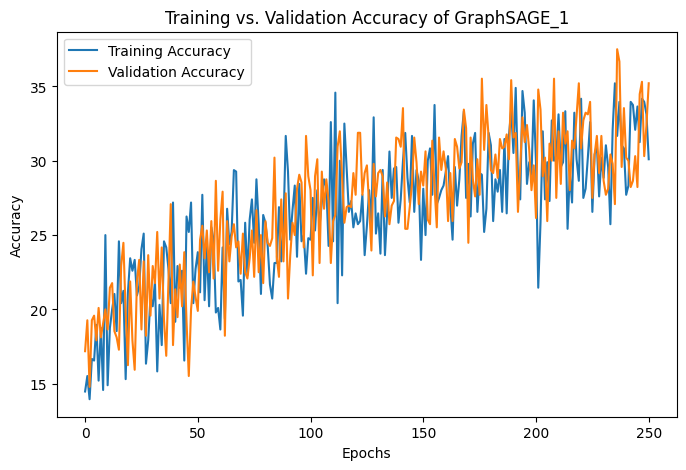

Test Loss: 1.7790218591690063 | Test Acc: 20.51%
Training Accuracy: 31.67| Validation Accuracy: 37.5| Epoch: 236


In [103]:
import torch.nn as nn


batch_size = 32
train_loader, val_loader, test_loader = loader(enzymes, batch_size = batch_size)
sage  = GraphSAGE_1(num_layers=4).to(device)
model = sage
#model, train_acc, val_acc, epochs = train_1(model, train_loader, lr = 0.0001, epochs = 100, i = 1)
model, train_acc, val_acc, epochs = train_1(model, train_loader, lr = 0.0001, epochs = 250, i = 1, rewired_edge_index=None)
#test_loss, test_acc = test(model, test_loader)
test_loss, test_acc = test(model, test_loader, rewired_edge_index= None)



print(f'Test Loss: {test_loss} | Test Acc: {test_acc}%')
print(f'Training Accuracy: {train_acc}| Validation Accuracy: {val_acc}| Epoch: {epochs}')


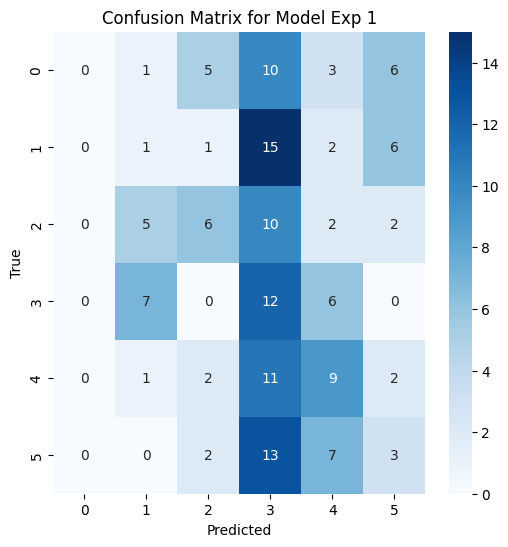

Classification Report for Model Exp 1:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        25
     Class 1       0.07      0.04      0.05        25
     Class 2       0.38      0.24      0.29        25
     Class 3       0.17      0.48      0.25        25
     Class 4       0.31      0.36      0.33        25
     Class 5       0.16      0.12      0.14        25

    accuracy                           0.21       150
   macro avg       0.18      0.21      0.18       150
weighted avg       0.18      0.21      0.18       150



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

(array([[ 0,  1,  5, 10,  3,  6],
        [ 0,  1,  1, 15,  2,  6],
        [ 0,  5,  6, 10,  2,  2],
        [ 0,  7,  0, 12,  6,  0],
        [ 0,  1,  2, 11,  9,  2],
        [ 0,  0,  2, 13,  7,  3]]),
 '              precision    recall  f1-score   support\n\n     Class 0       0.00      0.00      0.00        25\n     Class 1       0.07      0.04      0.05        25\n     Class 2       0.38      0.24      0.29        25\n     Class 3       0.17      0.48      0.25        25\n     Class 4       0.31      0.36      0.33        25\n     Class 5       0.16      0.12      0.14        25\n\n    accuracy                           0.21       150\n   macro avg       0.18      0.21      0.18       150\nweighted avg       0.18      0.21      0.18       150\n')

In [71]:
c_matplot(model, test_loader,1, rewired_edge_index= None)

### Better training Step implementation - modified - Training 2

In [104]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score, precision_recall_fscore_support
import wandb  # Optional for logging
from tqdm import tqdm
import matplotlib.pyplot as plt

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_epoch(model, loader, criterion, optimizer, device, rewired_edge_index=None):
    model.train()
    total_loss = 0
    predictions = []
    labels = []

    for batch_idx, data in enumerate(loader):
        data = data.to(device)

        optimizer.zero_grad()

        # Forward pass
        if rewired_edge_index is not None:
            out = model(data.x, data.edge_index, data.batch, rewired_edge_index=rewired_edge_index[batch_idx])
        else:
            out = model(data.x, data.edge_index, data.batch)

        # Calculate loss
        loss = criterion(out, data.y.long())
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        # Store predictions and labels
        pred = out.argmax(dim=-1)
        predictions.extend(pred.cpu().numpy())
        labels.extend(data.y.cpu().numpy())

        total_loss += loss.item() * data.num_graphs

    # Calculate metrics
    avg_loss = total_loss / len(loader.dataset)
    accuracy = np.mean(np.array(predictions) == np.array(labels))
    macro_f1 = f1_score(labels, predictions, average='macro')

    return avg_loss, accuracy, macro_f1

@torch.no_grad()
def evaluate(model, loader, criterion, device, rewired_edge_index=None):
    model.eval()
    total_loss = 0
    predictions = []
    labels = []

    for batch_idx, data in enumerate(loader):
        data = data.to(device)

        # Get model output
        if rewired_edge_index is not None:
            out = model(data.x, data.edge_index, data.batch, rewired_edge_index=rewired_edge_index[batch_idx])
        else:
            out = model(data.x, data.edge_index, data.batch)

        # Compute loss
        loss = criterion(out, data.y.long())
        total_loss += loss.item() * data.num_graphs

        # Binarize predictions
        pred = out.argmax(dim=-1)
        predictions.extend(pred.cpu().numpy())
        labels.extend(data.y.cpu().numpy())

    avg_loss = total_loss / len(loader.dataset)
    accuracy = np.mean(np.array(predictions) == np.array(labels))
    macro_f1 = f1_score(labels, predictions, average='macro')

    return avg_loss, accuracy, macro_f1

def train(model, train_loader, val_loader, config, i=None, rewiring_edge_index=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Initialize training components
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'])
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'])

    # Training tracking
    best_metrics = {
        'train': {'f1': 0, 'loss': float('inf'), 'accuracy': 0},
        'val': {'f1': 0, 'loss': float('inf'), 'accuracy': 0}
    }
    train_metrics, val_metrics = [], []

    for epoch in tqdm(range(config['epochs'])):
        # Training phase
        train_loss, train_acc, train_f1 = train_epoch(
            model, train_loader, criterion, optimizer, device, rewired_edge_index=rewiring_edge_index if rewiring_edge_index is not None else None
        )

        # Validation phase
        val_loss, val_acc, val_f1 = evaluate(
            model, val_loader, criterion, device, rewired_edge_index=rewiring_edge_index if rewiring_edge_index is not None else None
        )

        # Scheduler step
        scheduler.step()

        # Early stopping check
        early_stopping(val_loss)

        # Save best model based on validation F1 score
        if val_f1 > best_metrics['val']['f1']:
            best_metrics['val'] = {
                'f1': val_f1, 'loss': val_loss, 'accuracy': val_acc
            }
            best_metrics['train'] = {
                'f1': train_f1, 'loss': train_loss, 'accuracy': train_acc
            }
            best_model_state = model.state_dict().copy()

        # Store metrics for each epoch
        train_metrics.append({'loss': train_loss, 'accuracy': train_acc, 'f1': train_f1})
        val_metrics.append({'loss': val_loss, 'accuracy': val_acc, 'f1': val_f1})

        # Optional: Log to wandb
        if config['use_wandb']:
            wandb.log({
                'train_loss': train_loss,
                'train_acc': train_acc,
                'train_f1': train_f1,
                'val_loss': val_loss,
                'val_acc': val_acc,
                'val_f1': val_f1,
                'learning_rate': optimizer.param_groups[0]['lr']
            })

        # Print metrics at intervals
        if epoch % config['print_every'] == 0:
            print(f'Epoch {epoch:03d}:')
            print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}')

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Load best model
    model.load_state_dict(best_model_state)
    print("\nBest Train Metrics:", best_metrics['train'])
    print("Best Validation Metrics:", best_metrics['val'])
    model_name = type(model).__name__
    i = i if i is not None else ''
    torch.save(best_model_state, f'Over_Squashing_GNNs/models/Enzyme_results/best_models/{model_name}_rewiring_{i}.pth')

    return model, train_metrics, val_metrics, best_metrics

def plot_training_metrics(train_metrics, val_metrics):
    plt.figure(figsize=(15, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot([x['loss'] for x in train_metrics], label='Train Loss')
    plt.plot([x['loss'] for x in val_metrics], label='Val Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot([x['accuracy'] for x in train_metrics], label='Train Accuracy')
    plt.plot([x['accuracy'] for x in val_metrics], label='Val Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot F1 score
    plt.subplot(1, 3, 3)
    plt.plot([x['f1'] for x in train_metrics], label='Train F1')
    plt.plot([x['f1'] for x in val_metrics], label='Val F1')
    plt.title('F1 Score over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

  0%|          | 1/500 [00:00<00:59,  8.38it/s]

Epoch 000:
Train Loss: 1.8274, Acc: 0.2167, F1: 0.1378
Val Loss: 1.8346, Acc: 0.1704, F1: 0.0882


  1%|▏         | 7/500 [00:00<00:50,  9.82it/s]

Epoch 005:
Train Loss: 1.8166, Acc: 0.1667, F1: 0.1186
Val Loss: 1.8370, Acc: 0.1444, F1: 0.0999


  3%|▎         | 13/500 [00:01<00:49,  9.88it/s]

Epoch 010:
Train Loss: 1.7806, Acc: 0.2167, F1: 0.1737
Val Loss: 1.8113, Acc: 0.1815, F1: 0.1446


  3%|▎         | 17/500 [00:01<00:50,  9.61it/s]

Epoch 015:
Train Loss: 1.7704, Acc: 0.2167, F1: 0.1682
Val Loss: 1.8126, Acc: 0.1852, F1: 0.1506


  5%|▍         | 23/500 [00:02<00:50,  9.53it/s]

Epoch 020:
Train Loss: 1.7599, Acc: 0.2278, F1: 0.1742
Val Loss: 1.8103, Acc: 0.2111, F1: 0.1767


  6%|▌         | 28/500 [00:02<00:47,  9.90it/s]

Epoch 025:
Train Loss: 1.7297, Acc: 0.2278, F1: 0.1805
Val Loss: 1.8054, Acc: 0.1852, F1: 0.1618


  6%|▋         | 32/500 [00:03<00:47,  9.88it/s]

Epoch 030:
Train Loss: 1.7366, Acc: 0.2556, F1: 0.2230
Val Loss: 1.8065, Acc: 0.2296, F1: 0.2075


  7%|▋         | 37/500 [00:03<00:57,  8.10it/s]

Epoch 035:
Train Loss: 1.7302, Acc: 0.2278, F1: 0.1830
Val Loss: 1.8054, Acc: 0.2259, F1: 0.2033


  8%|▊         | 42/500 [00:04<00:59,  7.75it/s]

Epoch 040:
Train Loss: 1.7183, Acc: 0.2778, F1: 0.2395
Val Loss: 1.7998, Acc: 0.2296, F1: 0.2145


  9%|▉         | 47/500 [00:05<00:55,  8.22it/s]

Epoch 045:
Train Loss: 1.6864, Acc: 0.3000, F1: 0.2564
Val Loss: 1.7989, Acc: 0.2259, F1: 0.2050


 10%|█         | 51/500 [00:05<00:50,  8.95it/s]

Epoch 050:
Train Loss: 1.6815, Acc: 0.2833, F1: 0.2486
Val Loss: 1.8042, Acc: 0.2370, F1: 0.2262


 11%|█▏        | 57/500 [00:06<00:46,  9.54it/s]

Epoch 055:
Train Loss: 1.6583, Acc: 0.3389, F1: 0.3168
Val Loss: 1.8093, Acc: 0.2222, F1: 0.1971


 12%|█▏        | 62/500 [00:06<00:48,  9.00it/s]

Epoch 060:
Train Loss: 1.6661, Acc: 0.3278, F1: 0.3049
Val Loss: 1.8131, Acc: 0.2333, F1: 0.2126


 12%|█▏        | 62/500 [00:06<00:48,  8.97it/s]


Early stopping triggered

Best Train Metrics: {'f1': 0.24921418381954497, 'loss': 1.6929425372017755, 'accuracy': 0.2722222222222222}
Best Validation Metrics: {'f1': 0.24133576810081922, 'loss': 1.79815023916739, 'accuracy': 0.24444444444444444}

Best Training Metrics:
Loss: 1.6929, Accuracy: 0.2722, F1: 0.2492

Best Validation Metrics:
Loss: 1.7982, Accuracy: 0.2444, F1: 0.2413

Test Metrics:
Loss: 1.8102, Accuracy: 0.1933, F1: 0.1722


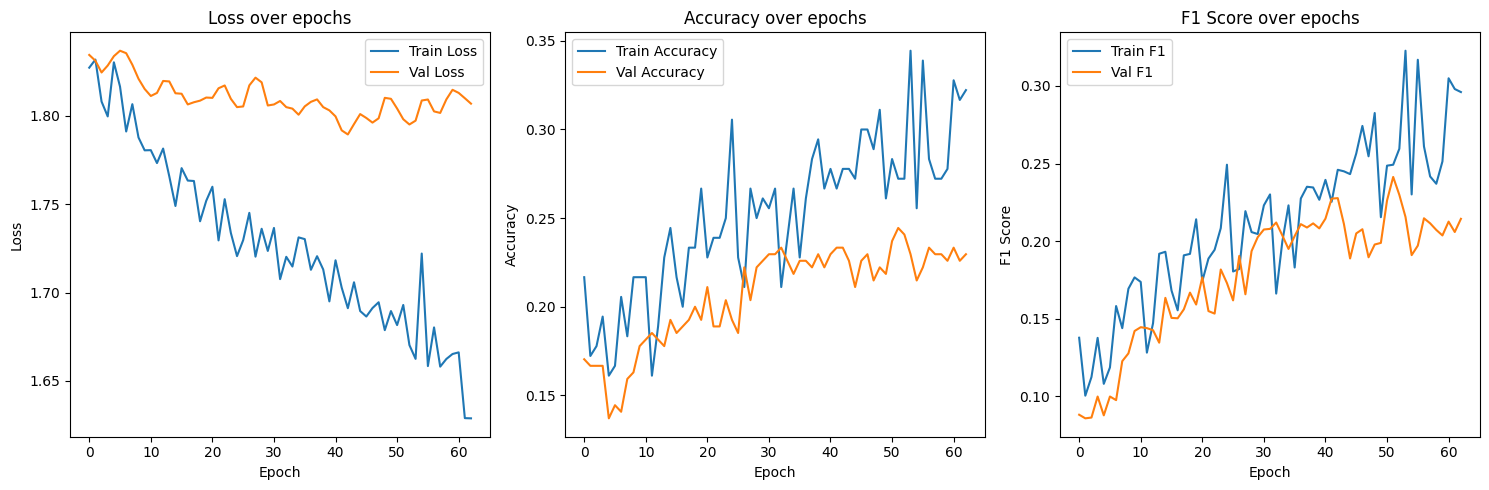

In [109]:
batch_size = 32
train_loader, val_loader, test_loader = loader(enzymes, batch_size=batch_size)
sage = GraphSAGE_1(num_layers=5).to(device)
model = sage

# Training configuration
config = {
    'lr': 0.001,
    'weight_decay': 1e-3,
    'epochs': 500,
    'print_every': 5,
    'use_wandb': False,  # Set to True if using wandb
    'early_stopping_patience': 20
}

# Train model
model, train_metrics, val_metrics, best_metrics = train(
    model,
    train_loader,
    val_loader,
    config,
    i=0,
    rewiring_edge_index=None
)

# Evaluate on test set
test_loss, test_acc, test_f1 = evaluate(model, test_loader, nn.CrossEntropyLoss(), device, rewired_edge_index=None)

# Print best metrics from training, validation, and test sets
print("\nBest Training Metrics:")
print(f"Loss: {best_metrics['train']['loss']:.4f}, Accuracy: {best_metrics['train']['accuracy']:.4f}, F1: {best_metrics['train']['f1']:.4f}")

print("\nBest Validation Metrics:")
print(f"Loss: {best_metrics['val']['loss']:.4f}, Accuracy: {best_metrics['val']['accuracy']:.4f}, F1: {best_metrics['val']['f1']:.4f}")

print("\nTest Metrics:")
print(f"Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, F1: {test_f1:.4f}")

# Plot results
plot_training_metrics(train_metrics, val_metrics)

In [ ]:
#import torch
# import torch.nn as nn
# import numpy as np
# from torch.optim.lr_scheduler import CosineAnnealingLR
# from sklearn.metrics import f1_score, precision_recall_fscore_support
# import wandb  # Optional for logging
# from tqdm import tqdm
# import matplotlib.pyplot as plt

# class EarlyStopping:
#     def __init__(self, patience=10, min_delta=0.001):
#         self.patience = patience
#         self.min_delta = min_delta
#         self.counter = 0
#         self.best_loss = None
#         self.early_stop = False

#     def __call__(self, val_loss):
#         if self.best_loss is None:
#             self.best_loss = val_loss
#         elif val_loss > self.best_loss - self.min_delta:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_loss = val_loss
#             self.counter = 0

# def train_epoch(model, loader, criterion, optimizer, device):
#     model.train()
#     total_loss = 0
#     predictions = []
#     labels = []

#     for data in loader:
#         data = data.to(device)
#         optimizer.zero_grad()

#         # Forward pass
#         out = model(data.x, data.edge_index, data.batch).squeeze()

#         # Calculate loss
#         loss = criterion(out, data.y.float())
#         loss.backward()

#         # Gradient clipping
#         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
#         optimizer.step()

#         # Store predictions and labels
#         pred = (out >= 0.5).float()
#         predictions.extend(pred.cpu().numpy())
#         labels.extend(data.y.cpu().numpy())

#         total_loss += loss.item() * data.num_graphs

#     # Calculate metrics
#     avg_loss = total_loss / len(loader.dataset)
#     accuracy = np.mean(np.array(predictions) == np.array(labels))
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

#     return avg_loss, accuracy, precision, recall, f1

# @torch.no_grad()
# def evaluate(model, loader, criterion, device):
#     model.eval()
#     total_loss = 0
#     predictions = []
#     labels = []

#     for data in loader:
#         data = data.to(device)

#         # Get model output and ensure correct shape
#         out = model(data.x, data.edge_index, data.batch).squeeze()

#         # Reshape output and target to match dimensions
#         if out.dim() == 0:  # Check if out is scalar
#             out = out.unsqueeze(0)
#         if data.y.dim() == 0:  # Check if target is scalar
#             data.y = data.y.unsqueeze(0)

#         # Compute loss
#         loss = criterion(out, data.y.float())
#         total_loss += loss.item() * data.num_graphs

#         # Binarize predictions
#         pred = (out >= 0.5).float()
#         predictions.extend(pred.cpu().numpy())
#         labels.extend(data.y.cpu().numpy())

#     avg_loss = total_loss / len(loader.dataset)
#     accuracy = np.mean(np.array(predictions) == np.array(labels))
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

#     return avg_loss, accuracy, precision, recall, f1


# def train(model, train_loader, val_loader, config):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model = model.to(device)

#     # Initialize training components
#     criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([config['pos_weight']]).to(device))
#     optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
#     scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'])
#     early_stopping = EarlyStopping(patience=config['early_stopping_patience'])

#     # Training tracking
#     best_metrics = {
#         'train': {'f1': 0, 'loss': float('inf'), 'accuracy': 0},
#         'val': {'f1': 0, 'loss': float('inf'), 'accuracy': 0}
#     }
#     train_metrics, val_metrics = [], []

#     for epoch in tqdm(range(config['epochs'])):
#         # Training phase
#         train_loss, train_acc, train_prec, train_rec, train_f1 = train_epoch(
#             model, train_loader, criterion, optimizer, device
#         )

#         # Validation phase
#         val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(
#             model, val_loader, criterion, device
#         )

#         # Scheduler step
#         scheduler.step()

#         # Early stopping check
#         early_stopping(val_loss)

#         # Save best model based on validation F1 score
#         if val_f1 > best_metrics['val']['f1']:
#             best_metrics['val'] = {
#                 'f1': val_f1, 'loss': val_loss, 'accuracy': val_acc
#             }
#             best_metrics['train'] = {
#                 'f1': train_f1, 'loss': train_loss, 'accuracy': train_acc
#             }
#             best_model_state = model.state_dict().copy()

#         # Store metrics for each epoch
#         train_metrics.append({'loss': train_loss, 'accuracy': train_acc, 'f1': train_f1})
#         val_metrics.append({'loss': val_loss, 'accuracy': val_acc, 'f1': val_f1})

#         # Optional: Log to wandb
#         if config['use_wandb']:
#             wandb.log({
#                 'train_loss': train_loss,
#                 'train_acc': train_acc,
#                 'train_f1': train_f1,
#                 'val_loss': val_loss,
#                 'val_acc': val_acc,
#                 'val_f1': val_f1,
#                 'learning_rate': optimizer.param_groups[0]['lr']
#             })

#         # Print metrics at intervals
#         if epoch % config['print_every'] == 0:
#             print(f'Epoch {epoch:03d}:')
#             print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}')
#             print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}')

#         if early_stopping.early_stop:
#             print("Early stopping triggered")
#             break

#     # Load best model
#     model.load_state_dict(best_model_state)
#     print("\nBest Train Metrics:", best_metrics['train'])
#     print("Best Validation Metrics:", best_metrics['val'])
#     return model, train_metrics, val_metrics, best_metrics

# def plot_training_metrics(train_metrics, val_metrics):
#     plt.figure(figsize=(15, 5))

#     # Plot loss
#     plt.subplot(1, 3, 1)
#     plt.plot([x['loss'] for x in train_metrics], label='Train Loss')
#     plt.plot([x['loss'] for x in val_metrics], label='Val Loss')
#     plt.title('Loss over epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Plot accuracy
#     plt.subplot(1, 3, 2)
#     plt.plot([x['accuracy'] for x in train_metrics], label='Train Accuracy')
#     plt.plot([x['accuracy'] for x in val_metrics], label='Val Accuracy')
#     plt.title('Accuracy over epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Plot F1 score
#     plt.subplot(1, 3, 3)
#     plt.plot([x['f1'] for x in train_metrics], label='Train F1')
#     plt.plot([x['f1'] for x in val_metrics], label='Val F1')
#     plt.title('F1 Score over epochs')
#     plt.xlabel('Epoch')
#     plt.ylabel('F1 Score')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

